<a href="https://colab.research.google.com/github/ManuelOtt-code/Project-DC/blob/master/04_Final_ML_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Welcome to our final step and congratulations for the endurance.

as before, just execute unless noted otherwise.

In [1]:
#import packages
# Install RDKit
!pip install rdkit

# Library imports
from pathlib import Path
from warnings import filterwarnings
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# RDKit
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator, rdMolDescriptors

# Scikit-learn
from sklearn import svm, metrics, clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import (
    auc, accuracy_score, recall_score, roc_curve, roc_auc_score, RocCurveDisplay
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import (
    VarianceThreshold, SelectKBest, f_classif, mutual_info_classif, chi2
)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay

import shap
import seaborn as sns

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 36.5 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

#path = '/content/drive/MyDrive/Colab Notebooks/DC_Antioxidants/Evaluation/'

Mounted at /content/drive


In [3]:
#get data from github (and function file)
!wget --timestamping https://github.com/ManuelOtt-code/Project-DC/raw/refs/heads/master//data_extraction%2Bcuration/Minimal_All_test_data.csv
!wget --timestamping https://github.com/ManuelOtt-code/Project-DC/raw/refs/heads/master//data_extraction%2Bcuration/Minimal_All_training_data.csv

--2025-06-26 16:08:08--  https://github.com/ManuelOtt-code/Project-DC/raw/refs/heads/master//data_extraction%2Bcuration/Minimal_All_test_data.csv
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ManuelOtt-code/Project-DC/refs/heads/master/data_extraction%2Bcuration/Minimal_All_test_data.csv [following]
--2025-06-26 16:08:09--  https://raw.githubusercontent.com/ManuelOtt-code/Project-DC/refs/heads/master/data_extraction%2Bcuration/Minimal_All_test_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41749 (41K) [text/plain]
Saving to: ‘Minimal_All_test_data.csv’

Minimal_All_test_da 100%[===

In [4]:
df_Minimal_All_training_data = pd.read_csv("Minimal_All_training_data.csv")
df_Minimal_All_test_data = pd.read_csv("Minimal_All_test_data.csv")

In [5]:
# Define a function to convert SMILES to morgan fingerprints
def smiles_to_fingerprints(smiles, n_bits=2048):
    """
    Converts a SMILES string to a molecular fingerprint.

    Parameters
    ----------
    smiles : str
        A SMILES string representing the molecular structure.
    n_bits : int, Optional, default: 1024
        The number of bits in the fingerprint.

    Returns
    -------
    list
        A list of integers representing the molecular fingerprint.
        Returns None if the SMILES string is invalid.
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=n_bits)
        return mfpgen.GetFingerprint(mol)
    else:
        return None # Return a zero vector if the SMILES is invalid

def generate_all_morgan_features(df, n_bits=2048):
    df.columns = df.columns.str.strip().str.lower()
    df['features'] = df['canonical_smiles'].apply(
        lambda s: list(smiles_to_fingerprints(s, n_bits)) if smiles_to_fingerprints(s, n_bits) is not None else [0]*n_bits
    )

    features_df = pd.DataFrame(df['features'].tolist(), index=df.index)
    features_df.columns = [f'fp_{i}' for i in range(n_bits)]

    df = pd.concat([df.drop('features', axis=1), features_df], axis=1)
    return df

In [6]:
#Generate Morgan fingerprints for selected files
morgan_fp_training = generate_all_morgan_features(df_Minimal_All_training_data)
morgan_fp_training.to_csv(f"Minimal_All_training_morgan.csv", index=False)

morgan_fp_test = generate_all_morgan_features(df_Minimal_All_test_data)
morgan_fp_test.to_csv(f"Minimal_All_test_morgan.csv", index=False)

In [7]:
# #alternative feature selection

# def drop_non_numeric_columns(df):
#     """Drops columns from a DataFrame that do not contain numeric values.

#     Args:
#         df: The input DataFrame.

#     Returns:
#         A new DataFrame with non-numeric columns removed.
#     """
#     numeric_df = df.select_dtypes(include=np.number)
#     return numeric_df

In [8]:
df_training = pd.read_csv("Minimal_All_training_morgan.csv")
df_test = pd.read_csv("Minimal_All_test_morgan.csv")
# filename = 'Minimal-All-Morgan'

# === Normalize column names just once ===
df_training.columns = df_training.columns.str.strip().str.lower()
df_test.columns = df_test.columns.str.strip().str.lower()

X_train = df_training.drop(columns=['active', 'canonical_smiles']).to_numpy()
y_train = df_training["active"]

X_test = df_test.drop(columns=['active', 'canonical_smiles']).to_numpy()
y_test = df_test["active"]

In [9]:
print(X_train.shape)
print(X_test.shape)

(2956, 2048)
(739, 2048)


In [ ]:
# Define Preprocessing and Models
from sklearn.metrics import classification_report

model = RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=200, max_features='log2')
pipeline = Pipeline([
        ('scaler', MinMaxScaler()),#'scaler', StandardScaler()
        ("var_thresh", VarianceThreshold(threshold=0.01)),#light filtering of low variance features (more often seen than the 80% constant value method but should do approx the same)
        #("corr_filter", CorrelationFilter(threshold=0.95)), #custom light filtering of highly correlated features (removes feature with lower correlation to activity value)
        ("anova", SelectKBest(score_func=chi2, k=250)),  # Supervised Filter-Based Selection with ANOVA, k can be tuned
        ('classifier', model)
    ])


In [ ]:
# Train the model
print("Training the model...")
pipeline.fit(X_train, y_train)
print("Training complete.")

# Make predictions on the test set
print("Making predictions on the test set...")
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]
print("Predictions complete.")

# Evaluate the model and print metrics
print("\nModel Evaluation Metrics:")
print(classification_report(y_test, y_pred))





Training the model...
Training complete.
Making predictions on the test set...
Predictions complete.

Model Evaluation Metrics:
              precision    recall  f1-score   support

           0       0.77      0.70      0.73       229
           1       0.87      0.91      0.89       510

    accuracy                           0.84       739
   macro avg       0.82      0.80      0.81       739
weighted avg       0.84      0.84      0.84       739



Accuracy: 0.8430
AUC: 0.8925
Cohen's Kappa: 0.6230


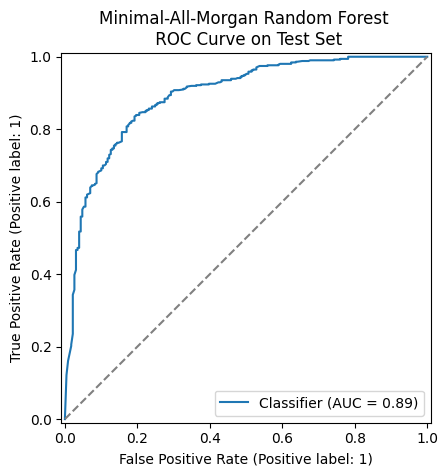

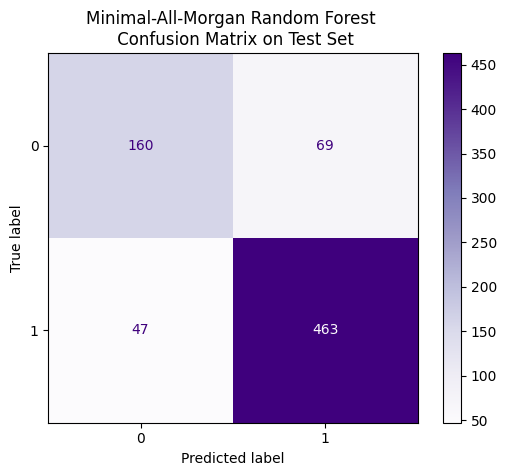

In [ ]:
# Calculate additional metrics
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
kappa = cohen_kappa_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {auc:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")

filename = 'Minimal-All-Morgan'
path = f"/content/drive/MyDrive/Colab Notebooks/DC_Antioxidants/Evaluation/Step2/"

# Plot ROC curve
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title(f"{filename} Random Forest \n ROC Curve on Test Set")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.savefig(f"{path}{filename} Random Forest ROC Curve on Test Set.png")
plt.show()

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap=plt.cm.Purples)
plt.title(f"{filename} Random Forest \n Confusion Matrix on Test Set")
plt.savefig(f"{path}{filename} Random Forest Confusion Matrix on Test Set.png")
plt.show()

#SHAP Analysis
I tried to do a SHAP analysis and thereafter extract the bits from the morgan fingerprints and visualize them.

In [ ]:
# Get the processed data from the pipeline (after scaling, variance thresholding, and anova selection)
X_test_processed = pipeline.named_steps['scaler'].transform(X_test)
X_test_processed = pipeline.named_steps['var_thresh'].transform(X_test_processed)
X_test_processed = pipeline.named_steps['anova'].transform(X_test_processed)

# Get the trained classifier from the pipeline
final_model = pipeline.named_steps['classifier']

# Get the names of the features that went into the classifier
feature_names_for_shap = feature_names_after_anova

# Create an Explainer object
explainer = shap.TreeExplainer(final_model, data=X_test_processed, feature_names=list(feature_names_for_shap))

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_processed)

100%|===================| 1476/1478 [04:23<00:00]       

Generating SHAP Summary Plot (Beeswarm)...


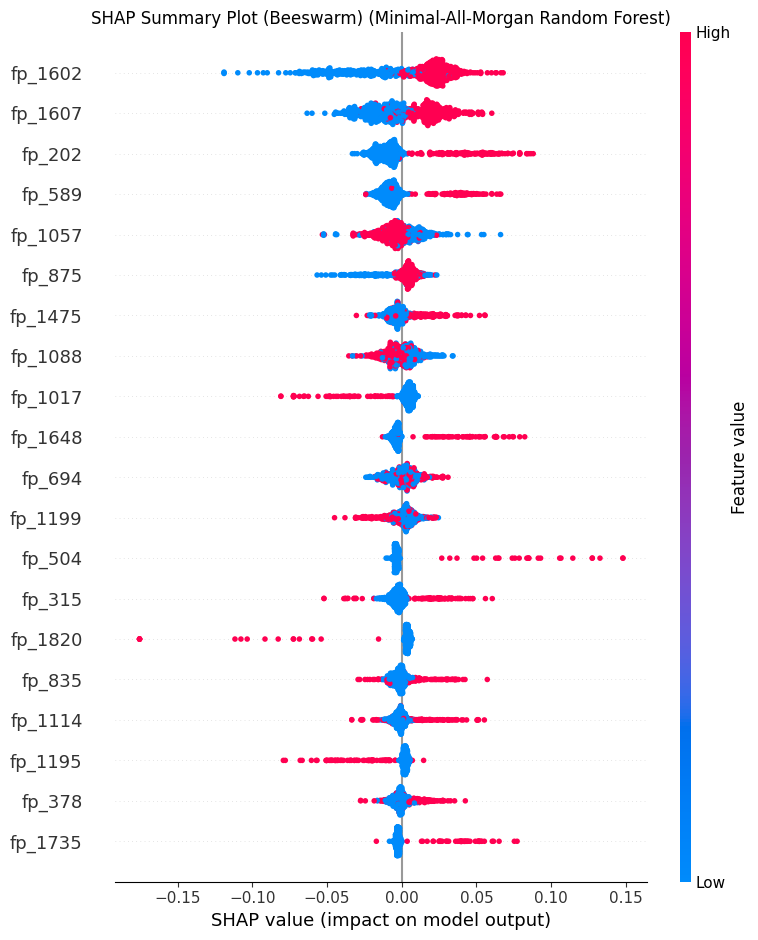

SHAP Beeswarm plot generated.


In [ ]:
shap_values_positive_class = shap_values[:, :, 1]

# Convert the SHAP values to a DataFrame
shap_df = pd.DataFrame(shap_values_positive_class, columns=feature_names_for_shap)

# Generate the SHAP beeswarm plot (summary plot)
print("Generating SHAP Summary Plot (Beeswarm)...")

# Ensure X_test_processed is used, which was created in the previous cell by applying pipeline transforms
# shap.summary_plot expects shap_values and features to be 2D numpy arrays
shap.summary_plot(shap_values_positive_class, features=X_test_processed, feature_names=feature_names_for_shap, show=False)
plt.title(f"SHAP Summary Plot (Beeswarm) ({filename} Random Forest)")
plt.tight_layout()
plt.savefig(f"{path}{filename} Random Forest SHAP Beeswarm Plot.png")
plt.show()
print("SHAP Beeswarm plot generated.")

In [ ]:
# Calculate the mean absolute SHAP value for each feature
mean_abs_shap = np.mean(np.abs(shap_values_positive_class), axis=0)

# Create a pandas Series
mean_abs_shap_series = pd.Series(mean_abs_shap, index=feature_names_for_shap)

# Sort by mean absolute SHAP value in descending order
sorted_mean_abs_shap = mean_abs_shap_series.sort_values(ascending=False)

# Get the top 5 feature names
top_20_shap_features = sorted_mean_abs_shap.head(20)

print("Top 5 Morgan Fingerprint Bits by Mean Absolute SHAP Value:")
print(top_20_shap_features)

Top 5 Morgan Fingerprint Bits by Mean Absolute SHAP Value:
fp_1602    0.026867
fp_1607    0.017673
fp_202     0.016636
fp_589     0.012184
fp_1057    0.009731
fp_875     0.008220
fp_1475    0.007746
fp_1088    0.007545
fp_1017    0.007408
fp_1648    0.006879
fp_694     0.006808
fp_1199    0.006524
fp_504     0.006459
fp_315     0.006305
fp_1820    0.006223
fp_835     0.005224
fp_1114    0.005119
fp_1195    0.005112
fp_378     0.005045
fp_1735    0.004923
dtype: float64


Extraction of the top 20 bits from the morgan fingerprints

In [ ]:
# Get the top 5 feature names from the sorted mean absolute SHAP values
top_20_shap_bits = top_20_shap_features.index.tolist()

print("\nTop 20 SHAP feature bit names:", top_20_shap_bits)

# Ensure the bits are integers for comparison
top_20_shap_bits_int = [int(bit.replace('fp_', '')) for bit in top_20_shap_bits]

print("\nTop 20 SHAP feature bit indices (integers):", top_20_shap_bits_int)

# Define a function to check if a molecule contains at least k of the top N bits
def contains_at_least_k_of_top_n_bits(fingerprint_list, top_n_bits_indices, k):
    """
    Checks if a molecule's fingerprint contains at least k of the top N bits.

    Parameters
    ----------
    fingerprint_list : list
        A list of integers representing the molecular fingerprint (1s and 0s).
    top_n_bits_indices : list
        A list of integer indices of the top N bits.
    k : int
        The minimum number of top N bits that must be present (set to 1).

    Returns
    -------
    bool
        True if the fingerprint contains at least k of the top N bits, False otherwise.
    """
    count = 0
    for bit_index in top_n_bits_indices:
        # Ensure the bit_index is within the bounds of the fingerprint list
        if 0 <= bit_index < len(fingerprint_list):
            if fingerprint_list[bit_index] == 1:
                count += 1
    return count >= k

# Apply the function to the test dataframe to filter molecules
# We need the fingerprint columns from the original df_test before dropping columns
# Find the fingerprint columns
fp_columns = [col for col in df_test.columns if col.startswith('fp_')]

# Apply the filter
# Use the original df_test to access both smiles and fingerprint data
molecules_with_top_bits = df_test[
    df_test[fp_columns].apply(
        lambda row: contains_at_least_k_of_top_n_bits(row.tolist(), top_20_shap_bits_int, k=11),
        axis=1
    )
]

print(f"\nFound {len(molecules_with_top_bits)} molecules in the test set that contain at least 10 of the top 20 SHAP bits.")

# Display the SMILES and activity of these molecules
print("\nMolecules containing at least 11 of the top 20 SHAP bits:")
print(molecules_with_top_bits[['canonical_smiles', 'active']])

# Optional: Save the filtered dataframe
# molecules_with_top_bits.to_csv(f"{path}{filename}_test_set_molecules_with_top_4_of_5_SHAP_bits.csv", index=False)
# print(f"\nFiltered molecules saved to {path}{filename}_test_set_molecules_with_top_4_of_5_SHAP_bits.csv")


Top 20 SHAP feature bit names: ['fp_1602', 'fp_1607', 'fp_202', 'fp_589', 'fp_1057', 'fp_875', 'fp_1475', 'fp_1088', 'fp_1017', 'fp_1648', 'fp_694', 'fp_1199', 'fp_504', 'fp_315', 'fp_1820', 'fp_835', 'fp_1114', 'fp_1195', 'fp_378', 'fp_1735']

Top 20 SHAP feature bit indices (integers): [1602, 1607, 202, 589, 1057, 875, 1475, 1088, 1017, 1648, 694, 1199, 504, 315, 1820, 835, 1114, 1195, 378, 1735]

Found 12 molecules in the test set that contain at least 10 of the top 20 SHAP bits.

Molecules containing at least 11 of the top 20 SHAP bits:
                                      canonical_smiles  active
64           CC(=O)c1cccc(NC(=O)/C=C/c2ccc(O)c(O)c2)c1       1
76                  O=C(/C=C/c1ccc(O)c(O)c1)CCc1ccccc1       1
98   COc1cccc(C(=O)/C=C/c2ccc(C(=O)Nc3nnc(-c4ccc(O)...       1
138  O=C(Nc1nnc(-c2ccc(O)c(O)c2)s1)c1ccc(/C=C/C(=O)...       1
205  COC(=O)[C@@H](Cc1c[nH]c2ccccc12)NC(=O)/C=C/c1c...       1
328  CC(=O)/C=C(O)/C(=C\c1ccc(O)c(O)c1)c1c(O)cc(/C=...       1
340  O=C(/C

In [ ]:
# Now, for the molecules identified, find which specific top 5 bits they contain
print("\nSpecific top 20 SHAP bits present in each identified molecule:")

# Iterate through the identified molecules
for index, row in molecules_with_top_bits.iterrows():
    smiles = row['canonical_smiles']
    # Get the fingerprint for this molecule from the row
    fingerprint = row[fp_columns].tolist()

    present_bits = []
    for bit_index in top_20_shap_bits_int:
        if 0 <= bit_index < len(fingerprint) and fingerprint[bit_index] == 1:
            present_bits.append(bit_index)

    print(f"Molecule (SMILES: {smiles}): Contains bits {present_bits}")


Specific top 20 SHAP bits present in each identified molecule:
Molecule (SMILES: CC(=O)c1cccc(NC(=O)/C=C/c2ccc(O)c(O)c2)c1): Contains bits [1602, 1607, 589, 1057, 875, 1475, 1088, 1017, 694, 315, 1820, 835, 1735]
Molecule (SMILES: O=C(/C=C/c1ccc(O)c(O)c1)CCc1ccccc1): Contains bits [1602, 1607, 589, 875, 1475, 1088, 694, 1199, 315, 835, 1735]
Molecule (SMILES: COc1cccc(C(=O)/C=C/c2ccc(C(=O)Nc3nnc(-c4ccc(O)c(O)c4)s3)cc2)c1): Contains bits [1602, 1607, 589, 1057, 875, 1475, 1088, 694, 315, 835, 378]
Molecule (SMILES: O=C(Nc1nnc(-c2ccc(O)c(O)c2)s1)c1ccc(/C=C/C(=O)c2ccccc2F)cc1): Contains bits [1602, 1607, 589, 875, 1475, 1088, 694, 1199, 315, 835, 378]
Molecule (SMILES: COC(=O)[C@@H](Cc1c[nH]c2ccccc12)NC(=O)/C=C/c1ccc(O)c2oc(-c3ccc(O)c(O)c3)cc12): Contains bits [1602, 1607, 589, 1057, 875, 1475, 1088, 694, 1199, 315, 835, 1114]
Molecule (SMILES: CC(=O)/C=C(O)/C(=C\c1ccc(O)c(O)c1)c1c(O)cc(/C=C/c2ccc(O)c(O)c2)oc1=O): Contains bits [1602, 1607, 589, 1057, 875, 1475, 1017, 694, 315, 835, 1735

In [ ]:
# Initialize global set to track used bits
used_bits = set()

# Define helper to assign only new bits
def filter_new_bits(bit_list):
    new_bits = [b for b in bit_list if b not in used_bits]
    used_bits.update(new_bits)
    return new_bits

# SMILES and deduplicated bit lists
smiles1 = "CC(=O)c1cccc(NC(=O)/C=C/c2ccc(O)c(O)c2)c1"
bits1   = filter_new_bits([1602, 1607, 589, 1057, 875, 1475, 1088, 1017, 694, 315, 1820, 835, 1735])

smiles2 = "O=C(/C=C/c1ccc(O)c(O)c1)CCc1ccccc1"
bits2   = filter_new_bits([1602, 1607, 589, 875, 1475, 1088, 694, 1199, 315, 835, 1735])

smiles3 = "COc1cccc(C(=O)/C=C/c2ccc(C(=O)Nc3nnc(-c4ccc(O)c(O)c4)s3)cc2)c1"
bits3   = filter_new_bits([1602, 1607, 589, 1057, 875, 1475, 1088, 694, 315, 835, 378])

smiles4 = "O=C(Nc1nnc(-c2ccc(O)c(O)c2)s1)c1ccc(/C=C/C(=O)c2ccccc2F)cc1"
bits4   = filter_new_bits([1602, 1607, 589, 875, 1475, 1088, 694, 1199, 315, 835, 378])

smiles5 = "COC(=O)[C@@H](Cc1c[nH]c2ccccc12)NC(=O)/C=C/c1ccc(O)c2oc(-c3ccc(O)c(O)c3)cc12"
bits5   = filter_new_bits([1602, 1607, 589, 1057, 875, 1475, 1088, 694, 1199, 315, 835, 1114])

smiles6 = "CC(=O)/C=C(O)/C(=C\\c1ccc(O)c(O)c1)c1c(O)cc(/C=C/c2ccc(O)c(O)c2)oc1=O"
bits6   = filter_new_bits([1602, 1607, 589, 1057, 875, 1475, 1017, 694, 315, 835, 1735])

smiles7 = "O=C(/C=C/c1ccc(O)c(O)c1)NCCCCCCNc1c2c(nc3ccccc13)CCCC2"
bits7   = filter_new_bits([1602, 1607, 589, 875, 1475, 1088, 694, 1199, 315, 835, 378, 1735])

smiles8 = "CC/C(=C\\c1ccc(O)c(O)c1)C(=O)N[C@@H](Cc1ccccc1)C(=O)C(=O)NCCc1ccc(OC)cc1"
bits8   = filter_new_bits([1602, 1607, 589, 1057, 875, 1475, 1088, 694, 1199, 315, 1735])

smiles9 = "O=C(/C=C/c1ccc(O)c(O)c1)Nc1ccccc1"
bits9   = filter_new_bits([1602, 1607, 589, 875, 1475, 1088, 694, 1199, 315, 835, 1735])

smiles10 = "COc1cc(/C=C/c2cc(O)c([C@H]3C(=O)C=C(C)O[C@@H]3c3ccc(O)c(O)c3)c(=O)o2)ccc1O"
bits10   = filter_new_bits([1602, 1607, 589, 1057, 875, 1475, 1088, 1648, 694, 315, 835])

smiles11 = "O=c1[nH]nc(-c2ccccc2)n1/N=C/c1ccc(O)c(O)c1"
bits11   = filter_new_bits([1602, 1607, 589, 875, 1475, 1088, 694, 1199, 315, 1114, 378, 1735])

smiles12 = "O=S(=O)(/C=C/c1ccc(O)c(O)c1)CCc1ccccc1"
bits12   = filter_new_bits([1602, 1607, 589, 875, 1475, 1088, 694, 1199, 315, 835, 1735])

print(smiles1, bits1)
print(smiles2, bits2)
print(smiles3, bits3)
print(smiles4, bits4)
print(smiles5, bits5)
print(smiles6, bits6)
print(smiles7, bits7)
print(smiles8, bits8)
print(smiles9, bits9)
print(smiles10, bits10)
print(smiles11, bits11)
print(smiles12, bits12)

CC(=O)c1cccc(NC(=O)/C=C/c2ccc(O)c(O)c2)c1 [1602, 1607, 589, 1057, 875, 1475, 1088, 1017, 694, 315, 1820, 835, 1735]
O=C(/C=C/c1ccc(O)c(O)c1)CCc1ccccc1 [1199]
COc1cccc(C(=O)/C=C/c2ccc(C(=O)Nc3nnc(-c4ccc(O)c(O)c4)s3)cc2)c1 [378]
O=C(Nc1nnc(-c2ccc(O)c(O)c2)s1)c1ccc(/C=C/C(=O)c2ccccc2F)cc1 []
COC(=O)[C@@H](Cc1c[nH]c2ccccc12)NC(=O)/C=C/c1ccc(O)c2oc(-c3ccc(O)c(O)c3)cc12 [1114]
CC(=O)/C=C(O)/C(=C\c1ccc(O)c(O)c1)c1c(O)cc(/C=C/c2ccc(O)c(O)c2)oc1=O []
O=C(/C=C/c1ccc(O)c(O)c1)NCCCCCCNc1c2c(nc3ccccc13)CCCC2 []
CC/C(=C\c1ccc(O)c(O)c1)C(=O)N[C@@H](Cc1ccccc1)C(=O)C(=O)NCCc1ccc(OC)cc1 []
O=C(/C=C/c1ccc(O)c(O)c1)Nc1ccccc1 []
COc1cc(/C=C/c2cc(O)c([C@H]3C(=O)C=C(C)O[C@@H]3c3ccc(O)c(O)c3)c(=O)o2)ccc1O [1648]
O=c1[nH]nc(-c2ccccc2)n1/N=C/c1ccc(O)c(O)c1 []
O=S(=O)(/C=C/c1ccc(O)c(O)c1)CCc1ccccc1 []


Tried to visualize the bits.


🔍 Molecule: CC(=O)c1cccc(NC(=O)/C=C/c2ccc(O)c(O)c2)c1
✅ Visualizing bit 1602 (environments: ((17, 1), (19, 1)))


[16:16:03] DEPRECATION WARNING: please use MorganGenerator


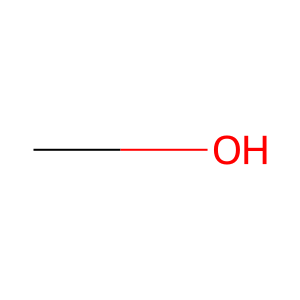

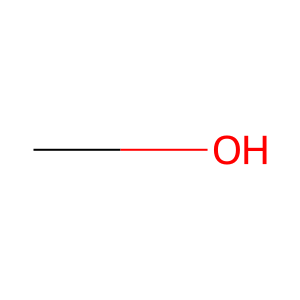

✅ Visualizing bit 1607 (environments: ((16, 1), (18, 1)))


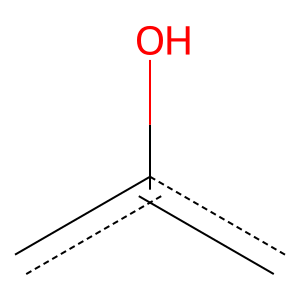

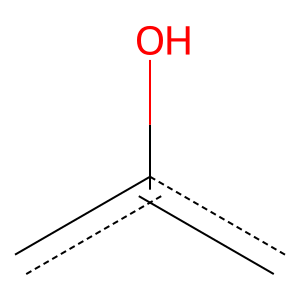

✅ Visualizing bit 589 (environments: ((18, 2),))


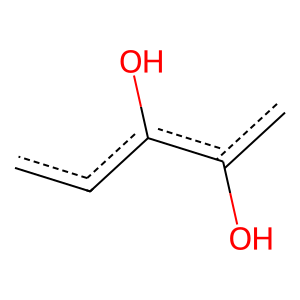

✅ Visualizing bit 1057 (environments: ((0, 0),))


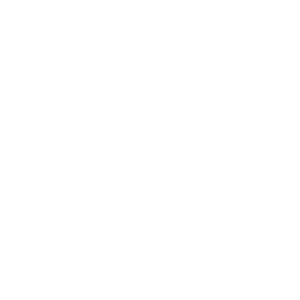

✅ Visualizing bit 875 (environments: ((21, 1), (20, 1)))


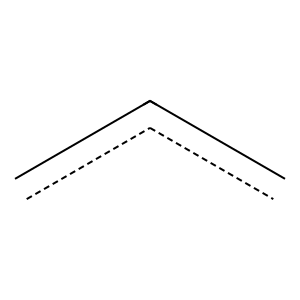

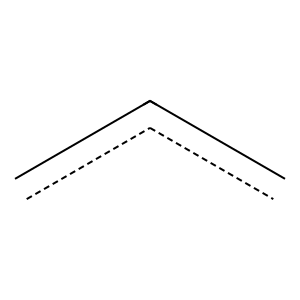

✅ Visualizing bit 1475 (environments: ((15, 2),))


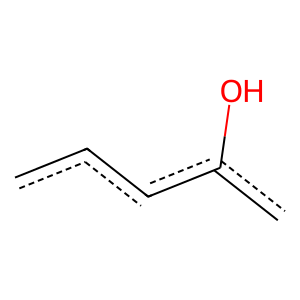

✅ Visualizing bit 1088 (environments: ((5, 1),))


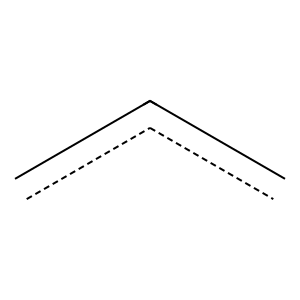

✅ Visualizing bit 1017 (environments: ((0, 1),))


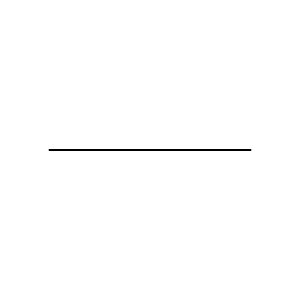

✅ Visualizing bit 694 (environments: ((11, 0), (12, 0)))


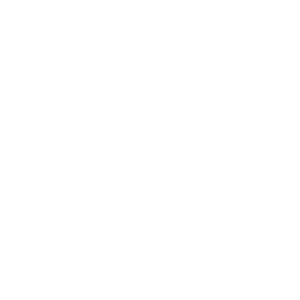

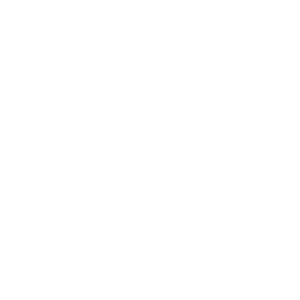

✅ Visualizing bit 315 (environments: ((16, 2),))


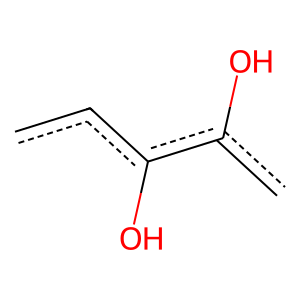

✅ Visualizing bit 1820 (environments: ((1, 1),))


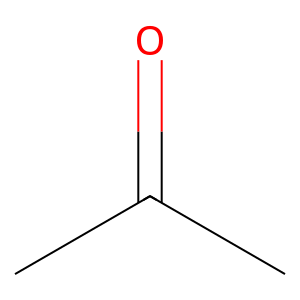

✅ Visualizing bit 835 (environments: ((12, 1),))


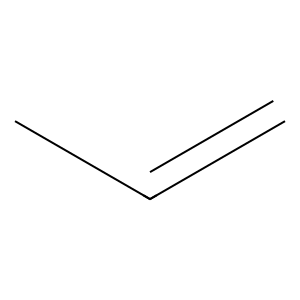

✅ Visualizing bit 1735 (environments: ((20, 2),))


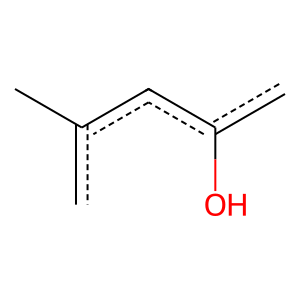


🔍 Molecule: O=C(/C=C/c1ccc(O)c(O)c1)CCc1ccccc1
✅ Visualizing bit 1199 (environments: ((16, 2), (18, 2)))


[16:16:04] DEPRECATION WARNING: please use MorganGenerator


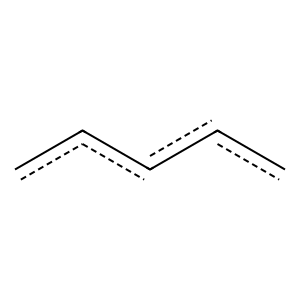

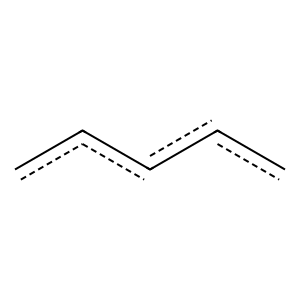


🔍 Molecule: COc1cccc(C(=O)/C=C/c2ccc(C(=O)Nc3nnc(-c4ccc(O)c(O)c4)s3)cc2)c1
✅ Visualizing bit 378 (environments: ((19, 0), (20, 0)))


[16:16:04] DEPRECATION WARNING: please use MorganGenerator


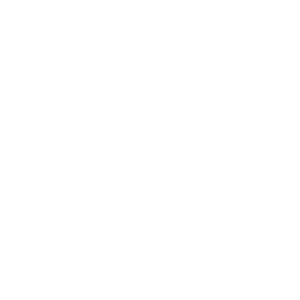

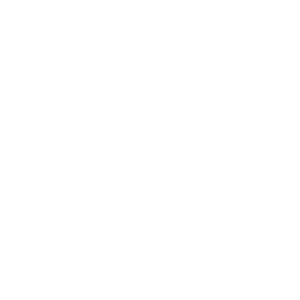


🔍 Molecule: COC(=O)[C@@H](Cc1c[nH]c2ccccc12)NC(=O)/C=C/c1ccc(O)c2oc(-c3ccc(O)c(O)c3)cc12
✅ Visualizing bit 1114 (environments: ((8, 0),))


[16:16:04] DEPRECATION WARNING: please use MorganGenerator


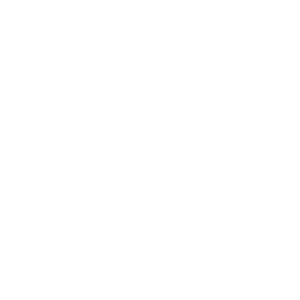


🔍 Molecule: COc1cc(/C=C/c2cc(O)c([C@H]3C(=O)C=C(C)O[C@@H]3c3ccc(O)c(O)c3)c(=O)o2)ccc1O
✅ Visualizing bit 1648 (environments: ((11, 1),))


[16:16:04] DEPRECATION WARNING: please use MorganGenerator


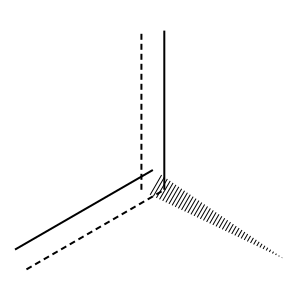

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from IPython.display import display

def visualize_morgan_bit_substructures(smiles, bit_indices, radius=2, nBits=2048):
    """
    Visualizes the substructures (atom environments) responsible for specific Morgan fingerprint bits.

    Parameters:
        smiles (str): The SMILES string of the molecule.
        bit_indices (list of int): Bit indices to visualize.
        radius (int): Radius used for Morgan fingerprint generation.
        nBits (int): Size of the fingerprint vector.
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print(f"❌ Invalid SMILES: {smiles}")
        return

    bitInfo = {}
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits, bitInfo=bitInfo)

    print(f"\n🔍 Molecule: {smiles}")
    for bit in bit_indices:
        if bit not in bitInfo:
            print(f"⚠️ Bit {bit} not found in this molecule.")
            continue

        print(f"✅ Visualizing bit {bit} (environments: {bitInfo[bit]})")
        envs = bitInfo[bit]
        for (atom_idx, env_radius) in envs:
            atoms = Chem.FindAtomEnvironmentOfRadiusN(mol, env_radius, atom_idx)
            amap = {}
            submol = Chem.PathToSubmol(mol, atoms, atomMap=amap)
            img = Draw.MolToImage(submol, size=(300, 300))
            display(img)

# -------------------------
smiles1 = "CC(=O)c1cccc(NC(=O)/C=C/c2ccc(O)c(O)c2)c1"
bits1   = [1602, 1607, 589, 1057, 875, 1475, 1088, 1017, 694, 315, 1820, 835, 1735]

smiles2 = "O=C(/C=C/c1ccc(O)c(O)c1)CCc1ccccc1"
bits2   = [1199]

smiles3 = "COc1cccc(C(=O)/C=C/c2ccc(C(=O)Nc3nnc(-c4ccc(O)c(O)c4)s3)cc2)c1"
bits3   = [378]

smiles5 = "COC(=O)[C@@H](Cc1c[nH]c2ccccc12)NC(=O)/C=C/c1ccc(O)c2oc(-c3ccc(O)c(O)c3)cc12"
bits5   = [1114]

smiles10 = "COc1cc(/C=C/c2cc(O)c([C@H]3C(=O)C=C(C)O[C@@H]3c3ccc(O)c(O)c3)c(=O)o2)ccc1O"
bits10   = [1648]


# -------------------------
# Visualize both
molecule_data = [
    (smiles1, bits1),
    (smiles2, bits2),
    (smiles3, bits3),
    (smiles5, bits5),
    (smiles10, bits10)
]

for smiles, bits in molecule_data:
    visualize_morgan_bit_substructures(smiles, bits)
